https://neptune.ai/blog/text-classification-tips-and-tricks-kaggle-competitions

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

import re, string, unicodedata
import random

from io import open

from bs4 import BeautifulSoup
from helper.contractions import CONTRACTION_MAP
from helper.slangs import SLANGS_MAP

import inflect
import unidecode
import emoji

import spacy
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from spacy.lemmatizer import Lemmatizer

#from spellchecker import SpellChecker
from nltk.tokenize import WhitespaceTokenizer

#from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from collections import  Counter

from textblob import TextBlob

# global variables
wtk = WhitespaceTokenizer()

In [2]:
# # spell checker
# spell = SpellChecker()
# def correct_spellings(words):
#     corrected_text = []
#     misspelled_words = spell.unknown(words)
#     for word in words:
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
            
#     return corrected_text


def spell_correction(text):
    text = TextBlob(text)
    return str(text.correct())


nlp = spacy.load('en_core_web_lg')
def spacy_tokenization_lemma(text):
    text_nlp = nlp(text)
    token_list = []
    for token in text_nlp:
        #token_list.append(token.text)
        if token.lemma_ != '-PRON-':
            token_list.append(token.lemma_)
        
    return token_list

##-- handle punctuations
def _remove_punct(text): 
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*_~'''
    for x in text.lower(): 
        if x in string.punctuation: 
            text = text.replace(x, "")
  
    return text


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_words.append(_remove_punct(word))
        
    return new_words


# convert emojis
def convert_emoji(text):
    text = emoji.demojize(text)
    return text


# remove html tags
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


# remove URL from text
def remove_url(words):
    """Remove URLs from a sample string"""
    # url_rule = r'(?P<url>https?://[^\s]+)'
    word_clean = []
    for word in words:
        text = re.sub(r"http\S+", "", word)
        if text:
            word_clean.append(text)
    return word_clean


### --- handle slangs
def unslang(text):
    """Convert slangs to corresponding english words"""
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    slangs = []
    for word in words:
        if word.upper() in SLANGS_MAP.keys():
            slangs.append(SLANGS_MAP[word.upper()])
        else:
            slangs.append(word)
            
    text_slangs = ' '.join(slangs)
    return text_slangs


def expand_contractions(text):
    wtk = WhitespaceTokenizer()
    words = wtk.tokenize(text)
    words_expand = []
    for word in words:
        if word in CONTRACTION_MAP.keys():
            words_expand.append(CONTRACTION_MAP[word])
        else:
            words_expand.append(word)
            
    text_expand = ' '.join(words_expand)
    return text_expand


##--- remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


# remove remianing non ascii characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


### --- lemmatization
#lemmatizer = Lemmatizer(lookups)
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer(word)
        lemmas.append(lemma)
    return lemmas


###---- Remove stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in spacy_stopwords:
            new_words.append(word)
    return new_words


def replace_compound_words(text):
    """Break compound words"""
    text = re.sub('/', ' / ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub('_', ' _ ', text)
    
    return text


# L33T vocabulary (SLOW)
# https://simple.wikipedia.org/wiki/Leet
# Local (only unknown words)
def convert_leet(word):
    # basic conversion 
    word = re.sub('0', 'o', word)
    word = re.sub('1', 'i', word)
    word = re.sub('3', 'e', word)
    word = re.sub('\$', 's', word)
    word = re.sub('\@', 'a', word)
    return word


def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    return text


def normalization(text):
    text = text.lower()
    text = replace_compound_words(text)
    text = spell_correction(text)
    text = convert_emoji(text)
    text = strip_html_tags(text)
    text = expand_contractions(text)
    text = unslang(text)
        
    # Tokenize
    words = spacy_tokenization_lemma(text)
    #words = remove_stopwords(words)
    words = remove_url(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    
    words = ' '.join(words)
    words = words.strip().lower()
    
    return words


In [3]:
train = pd.read_csv("data/train.csv", encoding='utf-8')

In [4]:
train.dropna(axis=0, subset=('text', 'label'), inplace=True)
#test.dropna(axis=0, subset=('text', ), inplace=True)

## EXPLORATORY DATA

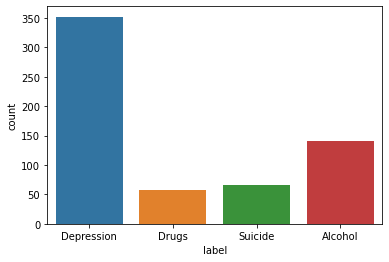

In [5]:
ax = sns.countplot(x='label', data=train)

In [6]:
%%time
train['text_norm'] = train['text'].apply(lambda x: normalization(x))

print(train.shape)
train.head()

(616, 4)
Wall time: 1min 9s


,ID,text,label,text_norm
0,SUAVK39Z,I feel that it was better I die Am happy,Depression,i feel that be well i die be happy
1,9JDAGUV3,Why do I get hallucinations?,Drugs,why do i get hallucination
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,i be stress due to lack of financial support i...
3,6UY7DX6Q,Why is life important?,Suicide,why be life important
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,how could i be help to go through the depression


Let's take a look at the number of characters present in each sentence. This can give us a rough idea about the news headline length.  
The average word length ranges between 3 to 9 with 6 being the most common length. this does not necesserily mean people use only short words. this distribution is skewed towards short words due to the number of stop words.


Text(0.5, 1.0, 'Average text length')

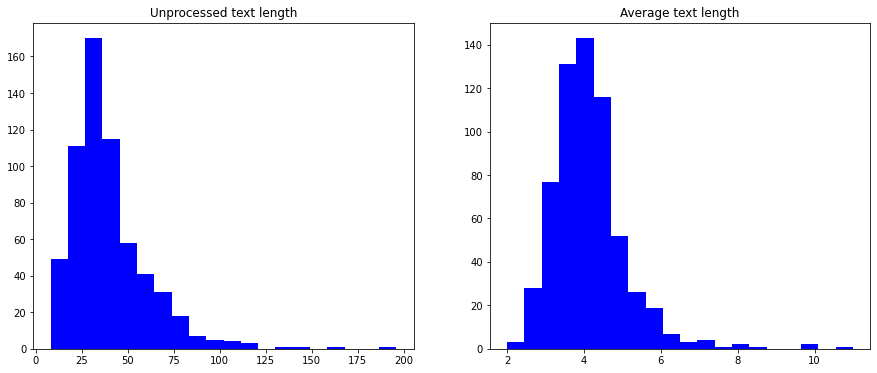

In [7]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
text_len = train['text'].str.len()
ax1.hist(text_len,color='blue', bins=20)
ax1.set_title('Unprocessed text length')

mean_len = train['text_norm'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
ax2.hist(mean_len,color='blue', bins=20)
ax2.set_title('Average text length')

### Analyzing stopwords.  
Analyzing the amount and the types of stopwords can give us some good insights into the data.  

In [8]:
import nltk
#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


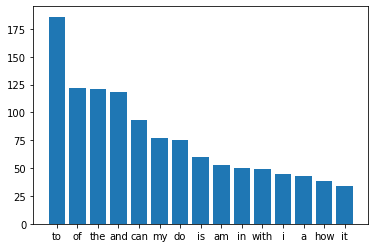

In [9]:
# plot top Stopwords 

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def most_frequent_stopwords(df, text):
        
    all_text = df[text].str.split()
    all_text = all_text.values.tolist()
    corpus=[word for i in all_text for word in i]

    
    dic=defaultdict(int)
    for word in corpus:
        if word in stopwords:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:15] 
    x,y=zip(*top)
    plt.bar(x,y)
    

most_frequent_stopwords(train, 'text')

So now we know which stopwords occur frequently in our text, let’s inspect which words other than these stopwords occur frequently.

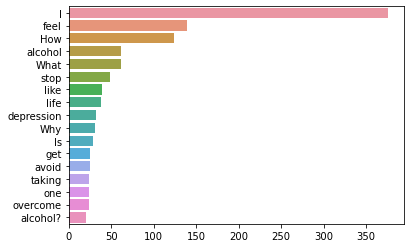

In [10]:

def frequent_non_stopwords(text):
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stopwords):
            x.append(word)
            y.append(count)
    # sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))
    sns.barplot(x=y,y=x)
    
frequent_non_stopwords(train['text'])   

### Ngram exploration.  
Looking at most frequent n-grams can give you a better understanding of the context in which the word was used.  
We can observe that the bigrams such as ‘how can’, ’feel like’ that are related to war dominate the news headlines.

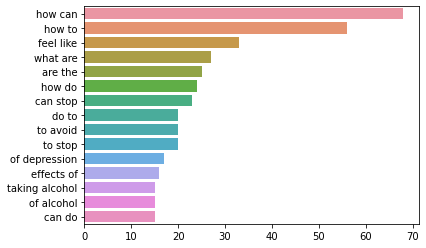

In [11]:
# Code Snippet for Top N-grams Barchart
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n_gram=2, top_n=10):

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:top_n]

    
    top_n_bigrams=_get_top_ngram(text,n_gram)[:top_n]
    x,y=map(list,zip(*top_n_bigrams))
    # sns.barplot(x='group', y='Values', data=df, estimator=lambda x: sum(x==0)*100.0/len(x))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(train['text'], 2, 15)

### word cloud

In [12]:
# Code Snippet for Wordcloud
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer,PorterStemmer

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
nlp = spacy.load('en_core_web_lg')
def spacy_lemmatizer(text):
    text_nlp = nlp(text)
    token_list = []
    for token in text_nlp:
        #token.text = token.text.strip("'") # strip 
        if token not in spacy_stopwords and token.lemma_ != '-PRON-':
            token_list.append(token.lemma_)
        
    return token_list

def plot_wordcloud(text):

    def _preprocess_text(texts):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for text in texts:
            tokens = spacy_lemmatizer(text)
            corpus.append(tokens)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

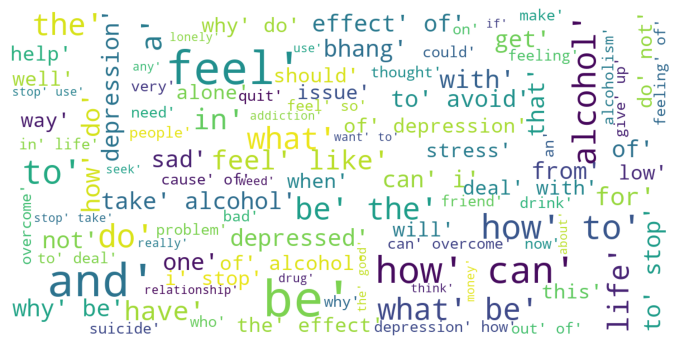

In [13]:
plot_wordcloud(train['text'])

### Textblob to check sentiments.  
We use textblob to evaluate the general sentiment of all the text.  
You can see that the polarity mainly ranges between 0.00 and 0.2. This indicates that the majority of the text are neutral.

In [14]:
#!pip install textblob 
from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    sns.barplot(x='group', y='Values', data=train, estimator=lambda x: sum(x==0)*100.0/len(x))
    
    polarity_score.hist(bins=10)

In [15]:
#plot_polarity_histogram(train['text'])


lets classify the news as negative, positive and neutral based on the scores

In [16]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,sentiment.value_counts())
    
    return sentiment


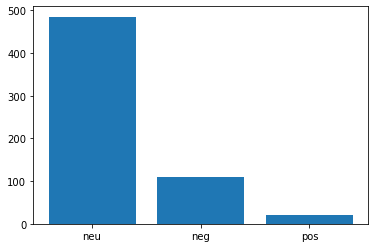

In [17]:
sentiment = plot_sentiment_barchart(train['text'], method='Vader')
train['polarity'] = sentiment

Let’s take a look at some of the positive and negative text

In [18]:
train[train['polarity']=='pos'].head(10)

,ID,text,label,text_norm,polarity
0,SUAVK39Z,I feel that it was better I die Am happy,Depression,i feel that be well i die be happy,pos
23,P4T442GZ,"Sadness,hatred Now feeling is happiness",Depression,sadness hatred now feel be happiness,pos
66,HD9XSQZD,Lonely and happiness,Depression,lonely and happiness,pos
92,DQYT5T05,Feeling lonelyNow I feel better,Depression,feel lonelynow i feel better,pos
112,SD3C3HNH,Challenging,Depression,challenging,pos
114,PBVEUVY5,I can't stop smoking weed because of the good ...,Drugs,i can not stop smoke weed because of the good ...,pos
150,UVSIAT7E,I feel like giving up everything,Depression,i feel like give up everything,pos
159,AWQDGRT6,i feel well okay,Depression,i feel well okay,pos
230,0UNXTGLP,How can i motivate myself when feeling low,Depression,how can i motivate when feel low,pos
242,X0YHNC8N,I feel like giving up,Depression,i feel like give up,pos


### Exploration through Parts of Speach Tagging.  
We can clearly see that the noun (NN) dominates in the text followed by prepositions (PRP).

In [19]:
# Code Snippet for Parts of Speach Barchart

from nltk.tokenize import word_tokenize
import seaborn as sns
from collections import Counter

def plot_parts_of_speach_barchart(text, n=10):
    #nltk.download('averaged_perceptron_tagger')

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(n))))
    
    sns.barplot(x=y,y=x)

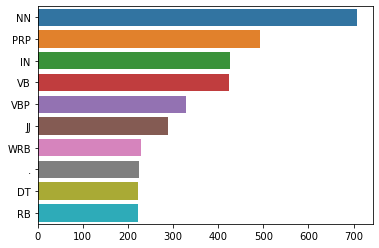

In [20]:
plot_parts_of_speach_barchart(train['text'])

investigate the most frequent noun used in our domain.  
Nouns such as 'alcohol', 'depression' and life dominate the text.

In [21]:
def plot_most_common_part_of_speach(text, part_of_speach='NN', n=10):
    #nltk.download('averaged_perceptron_tagger')
    
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type

    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(n))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)
    

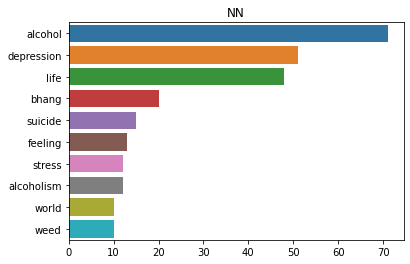

In [22]:
plot_most_common_part_of_speach(train['text'], n=10)

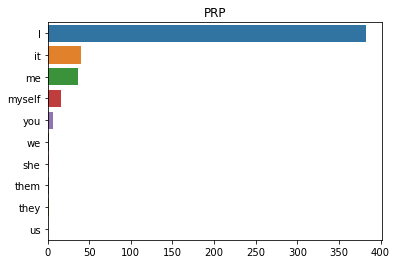

In [23]:
plot_most_common_part_of_speach(train['text'], 'PRP', 10)

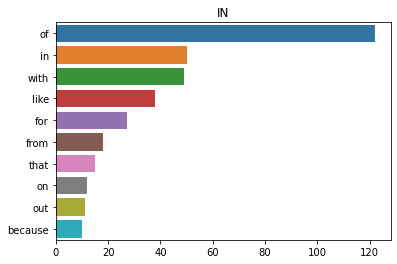

In [24]:
plot_most_common_part_of_speach(train['text'], 'IN', 10)

### Explore text complexity.  
It can be very informative to know how readable (difficult to read) the text is and what type of reader can fully understand it. Do we need a college degree to understand the message or a first-grader can clearly see what the point is?

You can actually put a number called readability index on a document or text. Readability index is a numeric value that indicates how difficult (or easy) it is to read and understand a text.

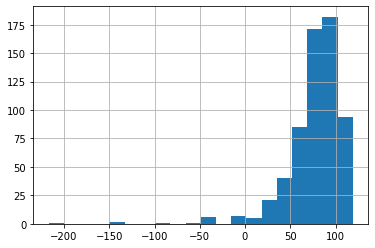

In [25]:
from textstat import flesch_reading_ease
#!pip install textstat

def text_complexity(text):
    reading = text.apply(lambda x : flesch_reading_ease(x))
    reading.hist(bins=20)
    
    return reading

reading = text_complexity(train['text'])

Almost all of the readability scores fall above 50. This means that an average 11-year-old student can read and understand the text. Let’s check all news headlines that have a readability score below 5

In [26]:
x=[i for i in range(len(reading)) if reading[i]<5]
train.iloc[x]['text'].head()

7                      I feel emotionally overwhelmed 
26                  Deteriorating academic performance
95     My feelings were chaotic,sad,isolatedNow better
97        Was sad,lonely,confusedNow happy and content
112                                        Challenging
Name: text, dtype: object

### Explore label distribution

In [27]:
train['label'].unique()

array(['Depression', 'Drugs', 'Suicide', 'Alcohol'], dtype=object)

It is clear that the number of words in text ranges from 1 to 15 and mostly falls between 2 to 5 words.

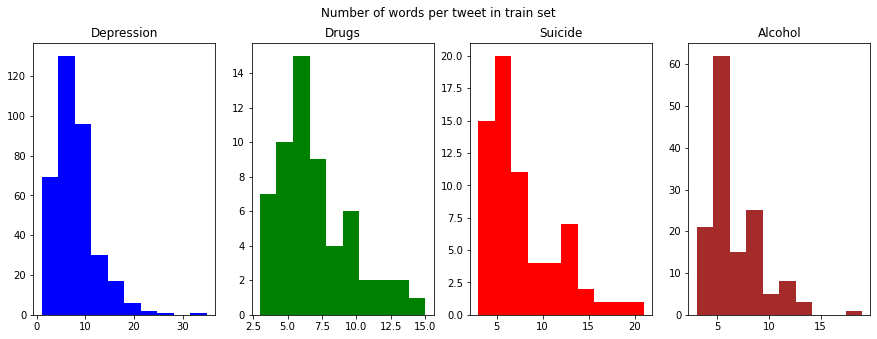

In [28]:
fig,(ax1,ax2, ax3, ax4) = plt.subplots(1,4,figsize=(15,5))

train_len = train[train['label'] == 'Depression']['text_norm'].str.split().map(lambda x: len(x))
ax1.hist(train_len,color='blue')
ax1.set_title('Depression')

train_len = train[train['label'] == 'Drugs']['text_norm'].str.split().map(lambda x: len(x))
ax2.hist(train_len,color='green')
ax2.set_title('Drugs')

train_len = train[train['label'] == 'Suicide']['text_norm'].str.split().map(lambda x: len(x))
ax3.hist(train_len,color='red')
ax3.set_title('Suicide')

train_len = train[train['label'] == 'Alcohol']['text_norm'].str.split().map(lambda x: len(x))
ax4.hist(train_len,color='brown')
ax4.set_title('Alcohol')

fig.suptitle('Number of words per tweet in train set')
plt.show()

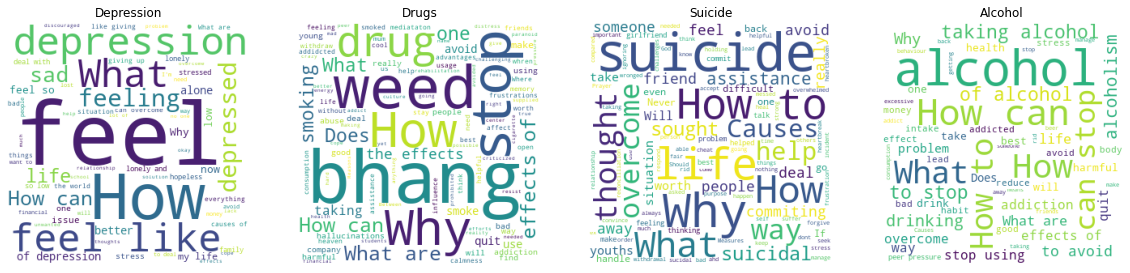

In [29]:
stopwords = set(STOPWORDS)

labels=['Depression', 'Drugs', 'Suicide', 'Alcohol']
fig, ax = plt.subplots(1,4, figsize=(20,11))
for i,s in enumerate(labels):
    
    tot_token = ''
    tot_token +=' '.join(train.loc[train['label']==s,'text'])
    wordcloud = WordCloud(width=300, height=300, background_color='white',
                     stopwords = stopwords, min_font_size=6).generate(tot_token)

    ax[i].imshow(wordcloud)  
    ax[i].set_title(s)
    ax[i].axis('off')

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


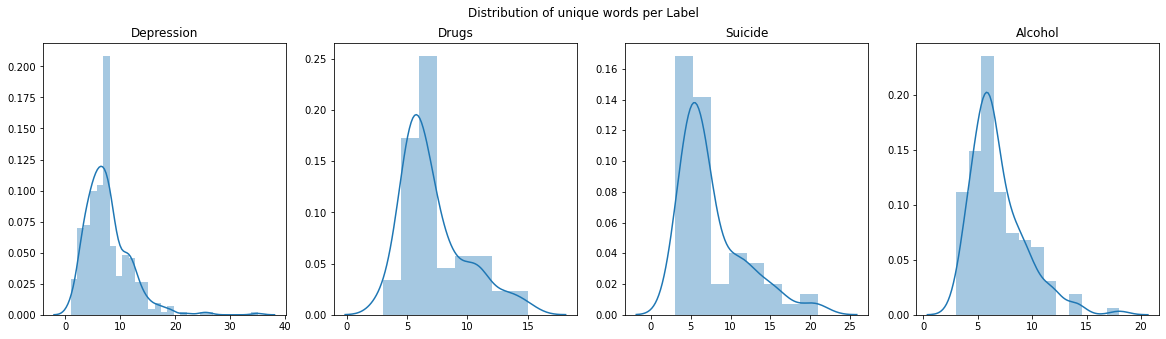

In [30]:
def distribution_unique_word(df):
    fig,ax = plt.subplots(1,4, figsize=(20,5))
    for i,s in enumerate(labels):
        new = train[train['label']==s]['text'].map(lambda x: len(set(x.split())))
        sns.distplot(new.values, ax=ax[i])
        ax[i].set_title(s)
    fig.suptitle('Distribution of unique words per Label')
    fig.show()

distribution_unique_word(train)

In [31]:
%%time
train['text_norm'] = train['text'].apply(lambda x: normalization(x))

print(train.shape)
train.head()

(616, 5)
Wall time: 53.6 s


,ID,text,label,text_norm,polarity
0,SUAVK39Z,I feel that it was better I die Am happy,Depression,i feel that be well i die be happy,pos
1,9JDAGUV3,Why do I get hallucinations?,Drugs,why do i get hallucination,neu
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,i be stress due to lack of financial support i...,neu
3,6UY7DX6Q,Why is life important?,Suicide,why be life important,neu
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,how could i be help to go through the depression,neu


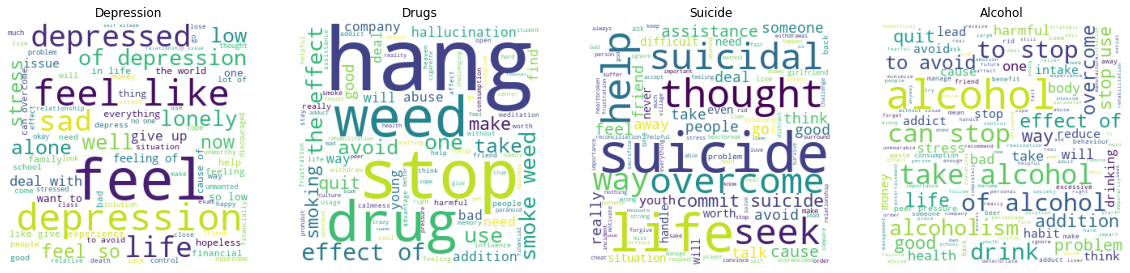

In [32]:
stopwords = set(STOPWORDS)

labels=['Depression', 'Drugs', 'Suicide', 'Alcohol']
fig, ax = plt.subplots(1,4, figsize=(20,11))
for i,s in enumerate(labels):
    
    tot_token = ''
    tot_token +=' '.join(train.loc[train['label']==s,'text_norm'])
    wordcloud = WordCloud(width=300, height=300, background_color='white',
                     stopwords = stopwords, min_font_size=6).generate(tot_token)

    ax[i].imshow(wordcloud)  
    ax[i].set_title(s)
    ax[i].axis('off')

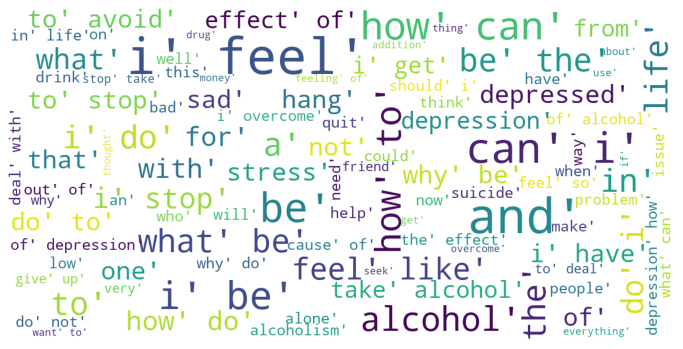

In [33]:
plot_wordcloud(train['text_norm'])

# BERT Implementation.  
https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

In [34]:
import numpy as np
import pandas as pd

import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

from textwrap import wrap

from sklearn.preprocessing import LabelEncoder

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616 entries, 0 to 615
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         616 non-null    object
 1   text       616 non-null    object
 2   label      616 non-null    object
 3   text_norm  616 non-null    object
 4   polarity   616 non-null    object
dtypes: object(5)
memory usage: 48.9+ KB


## Data Preprocessing.  
requirements for BERT data:  
    Add special tokens to separate sentences and do classification.  
    Pass sequences of constant length (introduce padding).  
    Create array of 0s (pad token) and 1s (real token) called attention mask.  

#### load a pre-trained BertTokenizer

In [36]:
#PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Maximum token length is 42


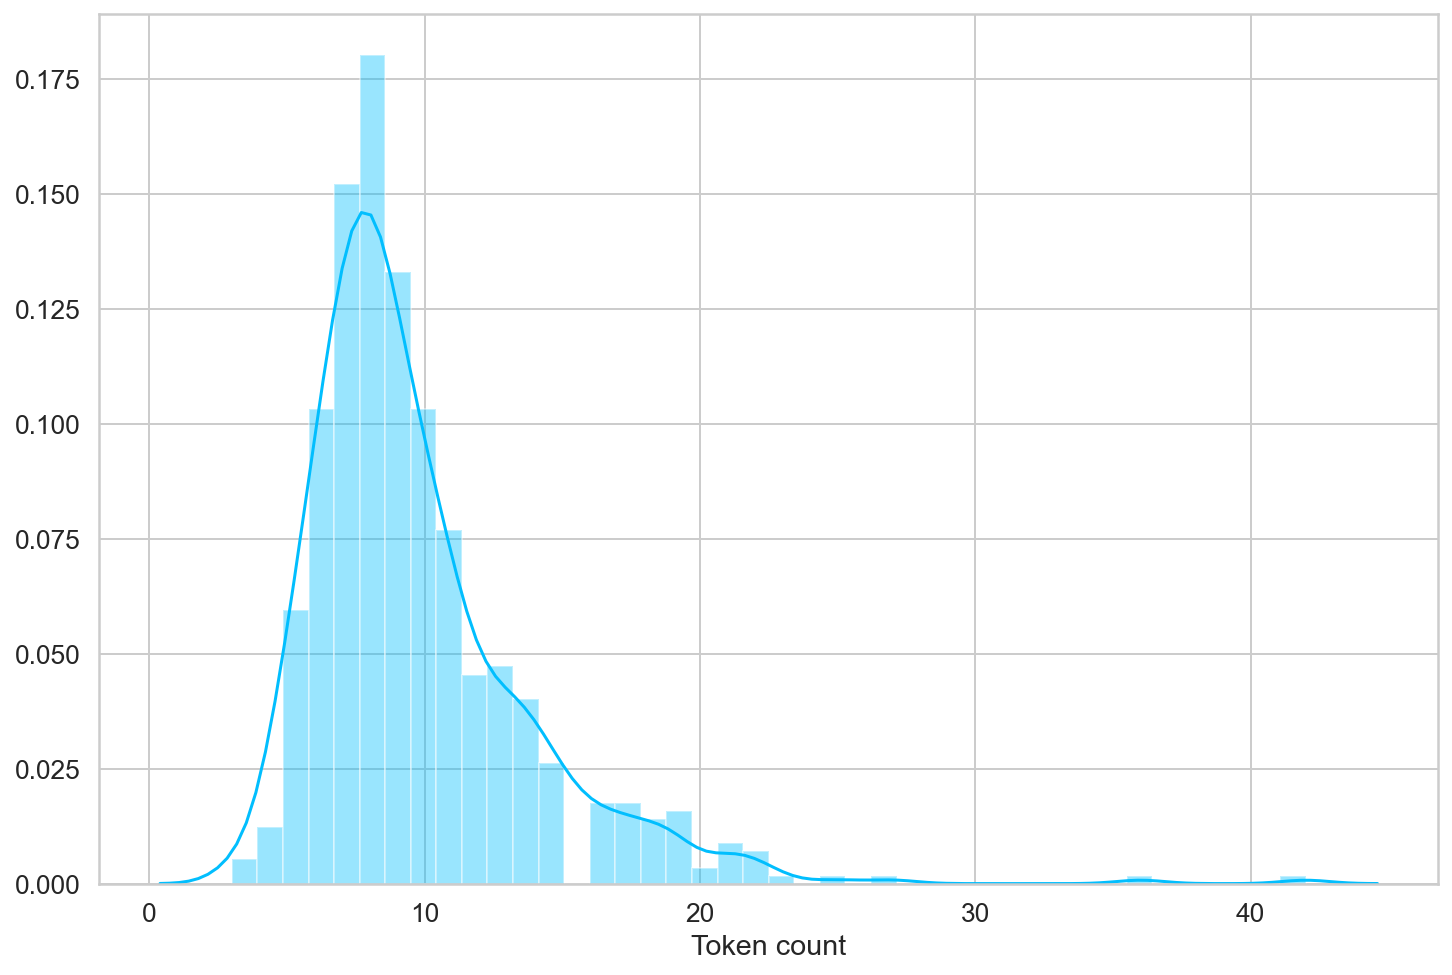

In [37]:
# Choosing Sequence Length
token_lens = []

for text in train.text_norm:
    tokens = tokenizer.encode(text, max_length=512)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlabel('Token count')


print("Maximum token length is {}".format(max(token_lens)))

In [38]:
MAX_LEN = 30

#### create data loaders for train, test and validation

In [39]:
class RightsDataset(Dataset):
    
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    

    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

    
def create_data_loader(df, tokenizer, max_len, batch_size):

    ds = RightsDataset(
        #texts=df.text.to_numpy(),
        texts=df.text_norm.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )



In [40]:
# encode class values as integers
Y = train['label'].values
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
#encoder.classes_
#encoder.inverse_transform([1])

# convert integers to dummy variables (i.e. one hot encoded)
#from keras.utils import np_utils
#labels = np_utils.to_categorical(encoded_Y)

train['target'] = encoded_Y


In [41]:
# split dataset for training
df_train, df_test = train_test_split(train, test_size=0.2,random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)

In [42]:
df_train.shape, df_val.shape, df_test.shape

((492, 6), (62, 6), (62, 6))

In [43]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

### Create a classifier that uses the BERT model.  
Characteristics:  
- We use a dropout layer for some regularization.  
- a fully-connected layer for our output.  

Note that we’re returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

In [44]:
# load pre-trained BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):

        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [46]:
class_names = list(train.label.unique())
model = SentimentClassifier(len(class_names))
#model = model.to(device)

### Training.  
The BERT authors have some recommendations for fine-tuning:  
- Batch size: 16, 32  
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  
- Number of epochs: 2, 3, 4  

In [47]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.CrossEntropyLoss().to(device)

In [48]:
# helper function for training our model for one epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:

#         input_ids = d["input_ids"].to(device)
#         attention_mask = d["attention_mask"].to(device)
#         targets = d["targets"].to(device)
        
        input_ids = d["input_ids"]
        attention_mask = d["attention_mask"]
        targets = d["targets"]
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
# helper function for evaluating our model for one epoch
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
#             input_ids = d["input_ids"].to(device)
#             attention_mask = d["attention_mask"].to(device)
#             targets = d["targets"].to(device)
            
            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            targets = d["targets"]
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [50]:

%%time
# training loop

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    model.train()
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    model.eval()
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val     loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 16777216 bytes. Buy new RAM!


#### the training vs validation accuracy.  
The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

In [51]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

(0.0, 1.0)

MemoryError: In RendererAgg: Out of memory

<Figure size 864x576 with 1 Axes>

### Evaluation

In [52]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1966080 bytes. Buy new RAM!


The accuracy is about 5% lower on the test set. Our model seems to generalize well.

### Prediction.  
This is similar to the evaluation function, except that we’re storing the text of the sentence and the predicted probabilities

In [ ]:
# helper function to get the predictions from our model:
def get_predictions(model, data_loader):

    model = model.eval()
    sentences = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]

            #input_ids = d["input_ids"].to(device)
            #attention_mask = d["attention_mask"].to(device)
            #targets = d["targets"].to(device)

            input_ids = d["input_ids"]
            attention_mask = d["attention_mask"]
            targets = d["targets"]

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            sentences.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return sentences, predictions, prediction_probs, real_values

In [ ]:
y_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

y_text = y_texts[idx]
true_label = y_test[idx]

pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': y_pred_probs[idx]
})

print("\n".join(wrap(y_text)))
print()
print(f'True label: {class_names[true_label]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
y_pred_probs[idx]

In [ ]:
pred_df

### Prediction for submission

In [ ]:
test = pd.read_csv("data/test.csv")
submission = pd.read_csv('data/SampleSubmission.csv')

In [ ]:
%%time
test['text_norm'] = test['text'].apply(lambda x: normalization(x))
print(test.shape)
test.head()

In [ ]:
class SubmissionDataset(Dataset):
    
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)
    

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

    
def submission_data_loader(df, tokenizer, max_len, batch_size):

    ds = RightsDataset(
        #texts=df.text.to_numpy(),
        texts=df.text_norm.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )